# Capstone Two - 5 Extended Modeling<a id='5'></a>

## 5.1 Contents<a id='5.1'></a>
* [5 Extended Modeling](#5)
  * [5.1 Contents](#5.1)
  * [5.2 Imports](#5.2)
  * [5.3 Load The Data](#5.3)
  * [5.4 Data Processing](#5.4)
  * [5.5 Modeling](#5.5)
    * [5.5.1 Apply auto_arima() for single timeseries](#5.5.1)
  

## 5.2 Imports<a id='5.2'></a>

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [5]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from prophet import Prophet

## 5.3 Load The Data<a id='5.3'></a>

In [13]:
data_dir = '../data/'

data_ori = pd.read_csv(data_dir+'train_all_groups.csv')
data_ori.head(3)

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred,year,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1


In [27]:
data = data_ori[['date', 'store_nbr', 'family', 'sales']]
data.set_index('date', inplace = True)
data.head(3)

,store_nbr,family,sales
date,,,
2013-01-01,1,AUTOMOTIVE,0.0
2013-01-01,1,BABY CARE,0.0
2013-01-01,1,BEAUTY,0.0


## 5.4 Data Processing<a id='5.4'></a>

In [63]:
stores = data['store_nbr'].unique()
families = data['family'].unique()

print(stores)
print(families)
print(len(stores), len(families))

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
54 33


In [75]:
grp = data.groupby(['store_nbr', 'family'])

df = pd.DataFrame()
col = 1

for s in stores:
    for f in families:
        grp_sel = grp.get_group((s, f))
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col})
        df = pd.concat([df, df_temp], axis=1)
        col = col+1

df.head()

,1,2,3,4,5,6,7,8,9,10,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,0.0,374.531,482.0,0.0,0.0,651.292,83.0,0.0,0.0,29.214
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,0.0,400.863,372.0,0.0,0.0,509.496,66.0,0.0,0.0,25.000
2013-01-04,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,...,0.0,310.878,324.0,0.0,0.0,332.672,57.0,0.0,0.0,11.000
2013-01-05,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,...,0.0,447.685,461.0,0.0,0.0,510.919,84.0,0.0,0.0,28.361


In [76]:
df.tail()

,1,2,3,4,5,6,7,8,9,10,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
date,,,,,,,,,,,,,,,,,,,,,
2017-08-11,1.0,0.0,1.0,1006.0,0.0,145.60700,4.0,341.0,343.0,64.302,...,5.0,309.245,373.0,11.0,2.0,525.224,112.10000,1453.078,140.0,23.831000
2017-08-12,6.0,0.0,3.0,1659.0,0.0,243.22000,3.0,351.0,526.0,99.488,...,2.0,260.298,400.0,7.0,10.0,383.387,129.90399,1419.264,138.0,16.859001
2017-08-13,1.0,0.0,1.0,803.0,0.0,136.67900,1.0,169.0,266.0,47.770,...,3.0,327.206,510.0,2.0,9.0,412.458,105.16900,1693.607,200.0,20.000000
2017-08-14,1.0,0.0,6.0,2201.0,0.0,346.03800,4.0,571.0,699.0,154.578,...,12.0,330.975,445.0,2.0,14.0,283.429,114.12000,1348.425,182.0,17.000000
2017-08-15,4.0,0.0,4.0,1942.0,0.0,329.54102,21.0,703.0,602.0,116.402,...,11.0,449.228,522.0,6.0,6.0,438.133,154.55300,2419.729,121.0,16.000000


In [83]:
# train-test split
n_train = len(df)-16
df_train = df[0:n_train]
df_test = df[n_train:]

## 5.5 Modeling<a id='5.5'></a>

### 5.5.1 Apply auto_arima() for single timeseries<a id='5.5.1'></a>

In [94]:
y1_train = df_train[1] # first column
y1_test = df_test[1]

In [95]:
# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(y1_train, 
                      d=None,               # let model determine 'd' (order of first-differencing)
                      start_p=0, start_q=0, # minimum p and q
                      max_p=15, max_q=15,   # maximum p and q
                      D=None,               # let model determine 'D' (order of the seasonal differencing)
                      trace=True)           # print status on the fits

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9096.121, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8682.001, Time=0.10 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7978.643, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9094.121, Time=0.04 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7980.616, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7980.612, Time=0.47 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7977.724, Time=0.80 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7978.946, Time=1.00 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7978.866, Time=0.98 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7977.120, Time=0.75 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.39 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7978.735, Time=1.40 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=7976.788, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7980.462, Time=0.16 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=7978.665, Time=0.35 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=inf, Time=0.23 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7977.594, Time=0.36 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=7978.424, Time=0.63 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 9.665 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1668
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -3984.394
Date:                Thu, 10 Aug 2023   AIC                           7976.788
Time:                        09:12:51   BIC                           7998.463
Sample:                             0   HQIC                          7984.820
                               - 1668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
m

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


In [100]:
# make forecasts
y1_pred = model.predict(y1_test.shape[0])  # predict N steps into the future

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [119]:
y1_test

date
2017-07-31    8.0
2017-08-01    5.0
2017-08-02    4.0
2017-08-03    3.0
2017-08-04    8.0
2017-08-05    5.0
2017-08-06    6.0
2017-08-07    7.0
2017-08-08    4.0
2017-08-09    7.0
2017-08-10    9.0
2017-08-11    1.0
2017-08-12    6.0
2017-08-13    1.0
2017-08-14    1.0
2017-08-15    4.0
Name: 1, dtype: float64

In [120]:
y1_pred

1668    4.379064
1669    4.553845
1670    4.357606
1671    4.357606
1672    4.357606
1673    4.357606
1674    4.357606
1675    4.357606
1676    4.357606
1677    4.357606
1678    4.357606
1679    4.357606
1680    4.357606
1681    4.357606
1682    4.357606
1683    4.357606
dtype: float64

In [118]:
# APE = ABS((actual - predicted) / actual)
APE_y1 = abs( (y1_test.values - y1_pred.values) / y1_test.values) # ma: moving average model

# MEAN(APE)
mAPE_y1 = np.mean(APE_y1)
print('MAPE:')
mAPE_y1

MAPE:


0.8585899440079136

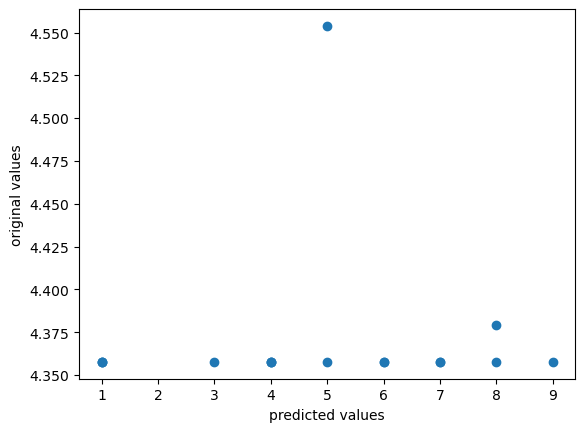

In [123]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y1_test.values, y1_pred.values)
plt.xlabel("predicted values")
plt.ylabel("original values")
# ax.axline((1,1), slope=1, color = 'red')
plt.show()